In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the Dataset
file_path = 'synthetic_dataset.csv'
df = pd.read_csv(file_path)

In [3]:
# Initial Exploration
print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Head:
   Internal Reference Invoice Number          Supplier Name  \
0           930380396       IN936392  Global Tech Solutions   
1           578983304       IN763468        Eco Electronics   
2           618862579       IN505158      Velocity Ventures   
3           364353921       IN301971        Eco Electronics   
4           253671350       IN113500       Blue Banana Inc.   

  Supplier Reference Invoice Date Posting Date    Due Date Payment Date  \
0            V_GL001   2024-07-13   2024-07-27  2024-08-23   2024-09-08   
1            V_EC001   2024-08-12   2024-08-16  2024-09-03   2024-09-10   
2            V_VE001   2024-06-14   2024-06-21  2024-06-30          NaN   
3            V_EC001   2024-07-26   2024-07-26  2024-09-04   2024-09-09   
4            V_BL001   2024-10-16   2024-10-26  2024-11-13   2024-12-04   

   Gross Amount  VAT Amount Currency Code Debit/Credit  
0       1606.12      321.22           EUR           Dr  
1        139.07       27.81           JPY 

## Preprocessing

In [4]:
# Standardize numeric fields
numeric_fields = ['Gross Amount', 'VAT Amount']
for field in numeric_fields:
    df[f"{field}_standardized"] = (df[field] - df[field].mean()) / df[field].std()

In [5]:
# Encode categorical fields
categorical_fields = ['Currency Code', 'Debit/Credit']
df_encoded = pd.get_dummies(df, columns=categorical_fields, drop_first=True)

In [6]:
# Handle missing values (example: fill NaNs in 'Payment Date' with a placeholder)
df['Payment Date'] = df['Payment Date'].fillna('1900-01-01')

In [7]:
# Save preprocessed data
df_encoded.to_csv('preprocessed_dataset.csv', index=False)
print("\nPreprocessed dataset saved as 'preprocessed_dataset.csv'")


Preprocessed dataset saved as 'preprocessed_dataset.csv'


## Field-Level Anomaly Detection
- Numeric Fields
- Categorical Fields
- Date Fields

### Numeric Fields

In [8]:
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

In [9]:
# Z-Score Analysis
df['Gross Amount_zscore'] = zscore(df['Gross Amount'])
df['VAT Amount_zscore'] = zscore(df['VAT Amount'])

# Flag outliers with Z-Score > 3 (both positive and negative)
df['Gross Amount_anomaly_zscore'] = df['Gross Amount_zscore'].apply(lambda x: 1 if abs(x) > 3 else 0)
df['VAT Amount_anomaly_zscore'] = df['VAT Amount_zscore'].apply(lambda x: 1 if abs(x) > 3 else 0)

In [10]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.05)  # 5% contamination for outliers
df['Gross Amount_anomaly_if'] = iso_forest.fit_predict(df[['Gross Amount']])
df['VAT Amount_anomaly_if'] = iso_forest.fit_predict(df[['VAT Amount']])

# Convert -1 (outlier) to 1 (anomaly) and 1 (inlier) to 0 (normal)
df['Gross Amount_anomaly_if'] = df['Gross Amount_anomaly_if'].apply(lambda x: 1 if x == -1 else 0)
df['VAT Amount_anomaly_if'] = df['VAT Amount_anomaly_if'].apply(lambda x: 1 if x == -1 else 0)

In [11]:
print("Anomalies detected in Gross Amount and VAT Amount:")
print(df[['Gross Amount', 'Gross Amount_anomaly_zscore', 'Gross Amount_anomaly_if']].head())

Anomalies detected in Gross Amount and VAT Amount:
   Gross Amount  Gross Amount_anomaly_zscore  Gross Amount_anomaly_if
0       1606.12                            0                        0
1        139.07                            0                        0
2       3096.84                            0                        0
3       2205.86                            0                        0
4       4093.04                            0                        0


### Categorical Fields

In [12]:
from fuzzywuzzy import fuzz

# Frequency Analysis: Get counts of each unique value
currency_counts = df['Currency Code'].value_counts()
print(f"Currency Code Frequency Analysis:\n{currency_counts}")

# Flag rare values (for example, values appearing less than 5 times)
rare_currencies = currency_counts[currency_counts < 5].index
df['Currency Code_anomaly_freq'] = df['Currency Code'].apply(lambda x: 1 if x in rare_currencies else 0)

# Fuzzy Matching: Detect similar currency names
def fuzzy_match_currency(value):
    if fuzz.ratio(value, "USD") < 80:  # Arbitrary threshold for fuzziness
        return 1  # Anomaly
    return 0  # Normal

df['Currency Code_anomaly_fuzzy'] = df['Currency Code'].apply(fuzzy_match_currency)

print("\nAnomalies detected in Currency Code:")
print(df[['Currency Code', 'Currency Code_anomaly_freq', 'Currency Code_anomaly_fuzzy']].head())


Currency Code Frequency Analysis:
Currency Code
USD    376
CAD    136
EUR    129
GBP    121
AUD    120
JPY    118
Name: count, dtype: int64

Anomalies detected in Currency Code:
  Currency Code  Currency Code_anomaly_freq  Currency Code_anomaly_fuzzy
0           EUR                           0                            1
1           JPY                           0                            1
2           USD                           0                            0
3           JPY                           0                            1
4           USD                           0                            0


C:\Users\Dhireen Kumar Rajak\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [14]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode categorical fields (e.g., Currency Code, Debit/Credit)
categorical_fields = ['Currency Code', 'Debit/Credit']
label_encoders = {}
for field in categorical_fields:
    le = LabelEncoder()
    df[f'{field}_encoded'] = le.fit_transform(df[field])
    label_encoders[field] = le

# Step 2: Apply One-Class SVM for anomaly detection on encoded categorical data
oc_svm = OneClassSVM(kernel='rbf', gamma='scale')  # 5% contamination for anomalies

# Detect anomalies for Currency Code and Debit/Credit
df['Currency Code_anomaly_ocsvm'] = oc_svm.fit_predict(df[['Currency Code_encoded']])
df['Debit/Credit_anomaly_ocsvm'] = oc_svm.fit_predict(df[['Debit/Credit_encoded']])

# Convert -1 (outlier) to 1 (anomaly) and 1 (inlier) to 0 (normal)
df['Currency Code_anomaly_ocsvm'] = df['Currency Code_anomaly_ocsvm'].apply(lambda x: 1 if x == -1 else 0)
df['Debit/Credit_anomaly_ocsvm'] = df['Debit/Credit_anomaly_ocsvm'].apply(lambda x: 1 if x == -1 else 0)

print("\nAnomalies detected in Currency Code and Debit/Credit using One-Class SVM:")
print(df[['Currency Code', 'Currency Code_anomaly_ocsvm', 'Debit/Credit', 'Debit/Credit_anomaly_ocsvm']].head())


Anomalies detected in Currency Code and Debit/Credit using One-Class SVM:
  Currency Code  Currency Code_anomaly_ocsvm Debit/Credit  \
0           EUR                            0           Dr   
1           JPY                            0           Dr   
2           USD                            1           Dr   
3           JPY                            0           Dr   
4           USD                            1           Dr   

   Debit/Credit_anomaly_ocsvm  
0                           1  
1                           1  
2                           1  
3                           1  
4                           1  


### Date Fields

In [15]:
# Delta Thresholding: Flag rows where Posting Date is earlier than Invoice Date
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'], errors='coerce')
df['Posting Date'] = pd.to_datetime(df['Posting Date'], errors='coerce')

df['Date_anomaly'] = df.apply(lambda row: 1 if row['Posting Date'] < row['Invoice Date'] else 0, axis=1)

print("\nDate-related anomalies detected (Posting Date < Invoice Date):")
print(df[['Invoice Date', 'Posting Date', 'Date_anomaly']].head())


Date-related anomalies detected (Posting Date < Invoice Date):
  Invoice Date Posting Date  Date_anomaly
0   2024-07-13   2024-07-27             0
1   2024-08-12   2024-08-16             0
2   2024-06-14   2024-06-21             0
3   2024-07-26   2024-07-26             0
4   2024-10-16   2024-10-26             0


## Row-Level Anomaly Detection
- Multivariate Analysis
    - Mahalanobis Distance
    - Autoencoders
- Rule-Based Checks

### Mahalanobis Distance

In [16]:
from scipy.spatial import distance
import numpy as np

# Step 1: Calculate the Mahalanobis Distance
# We will use numeric features like 'Gross Amount' and 'VAT Amount'
numeric_features = ['Gross Amount', 'VAT Amount']

# Compute the covariance matrix and the inverse of it
cov_matrix = np.cov(df[numeric_features].values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate the mean of the features
mean_vector = np.mean(df[numeric_features], axis=0)

# Mahalanobis Distance for each row
df['Mahalanobis_Distance'] = df.apply(lambda row: distance.mahalanobis(row[numeric_features], mean_vector, inv_cov_matrix), axis=1)

# Set a threshold to detect anomalies (e.g., distance > 3)
threshold = 3
df['Mahalanobis_Anomaly'] = df['Mahalanobis_Distance'].apply(lambda x: 1 if x > threshold else 0)

print("\nMahalanobis Distance and Anomaly Detection:")
print(df[['Gross Amount', 'VAT Amount', 'Mahalanobis_Distance', 'Mahalanobis_Anomaly']].head())



Mahalanobis Distance and Anomaly Detection:
   Gross Amount  VAT Amount  Mahalanobis_Distance  Mahalanobis_Anomaly
0       1606.12      321.22              1.448754                    0
1        139.07       27.81              1.533188                    0
2       3096.84      619.37              0.729148                    0
3       2205.86      441.17              0.767823                    0
4       4093.04      818.61              0.704841                    0


### Autoencoders

In [19]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Step 2: Autoencoder Setup
# Normalize the numeric data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_features])

# Define Autoencoder Model
autoencoder = Sequential()
autoencoder.add(Dense(64, input_dim=len(numeric_features), activation='relu'))
autoencoder.add(Dense(32, activation='relu'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(len(numeric_features), activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train Autoencoder
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Step 3: Calculate Reconstruction Error
reconstruction_error = np.mean(np.square(df_scaled - autoencoder.predict(df_scaled)), axis=1)

# Set a threshold to detect anomalies (e.g., reconstruction error > 0.1)
threshold_error = 0.1
df['Autoencoder_Anomaly'] = np.where(reconstruction_error > threshold_error, 1, 0)

print("\nAutoencoder Anomaly Detection:")
print(df[['Gross Amount', 'VAT Amount', 'Autoencoder_Anomaly']].head())


C:\Users\Dhireen Kumar Rajak\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Autoencoder Anomaly Detection:
   Gross Amount  VAT Amount  Autoencoder_Anomaly
0       1606.12      321.22                    1
1        139.07       27.81                    1
2       3096.84      619.37                    0
3       2205.86      441.17                    1
4       4093.04      818.61                    0


### Rule-Based Checks

In [20]:
# Step 3: Rule-Based Checks
df['VAT_Anomaly'] = np.where(df['VAT Amount'] != df['Gross Amount'] * 0.2, 1, 0)

# Example: if we had a Supplier-to-Currency mapping, we'd add a rule like:
# df['Currency_Anomaly'] = np.where(df['Currency Code'] != df['Supplier Currency'], 1, 0)

print("\nRule-Based Anomaly Detection (VAT):")
print(df[['Gross Amount', 'VAT Amount', 'VAT_Anomaly']].head())



Rule-Based Anomaly Detection (VAT):
   Gross Amount  VAT Amount  VAT_Anomaly
0       1606.12      321.22            1
1        139.07       27.81            1
2       3096.84      619.37            1
3       2205.86      441.17            1
4       4093.04      818.61            1


## Visualization

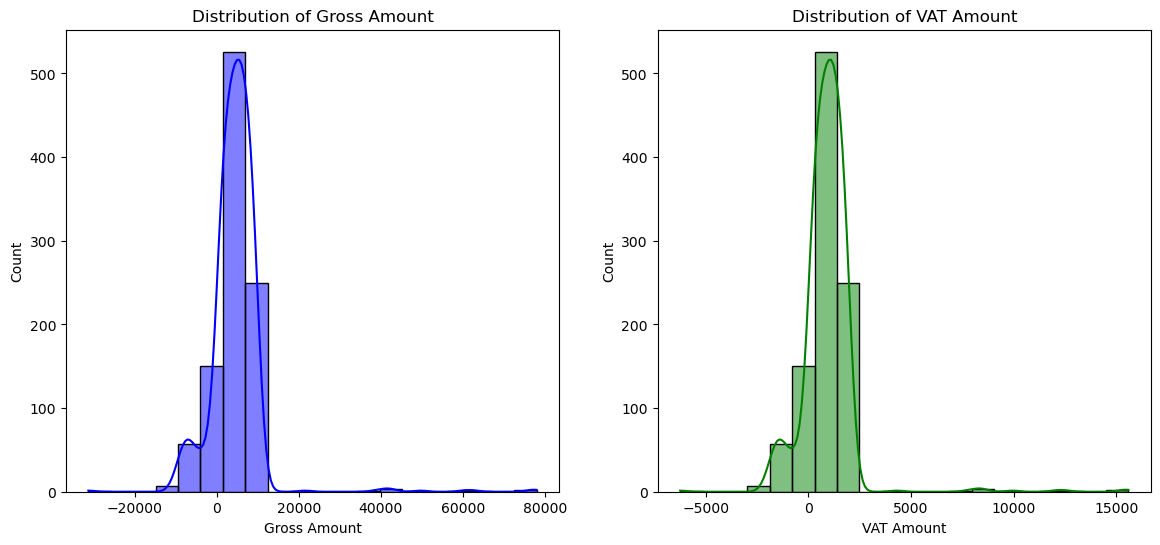

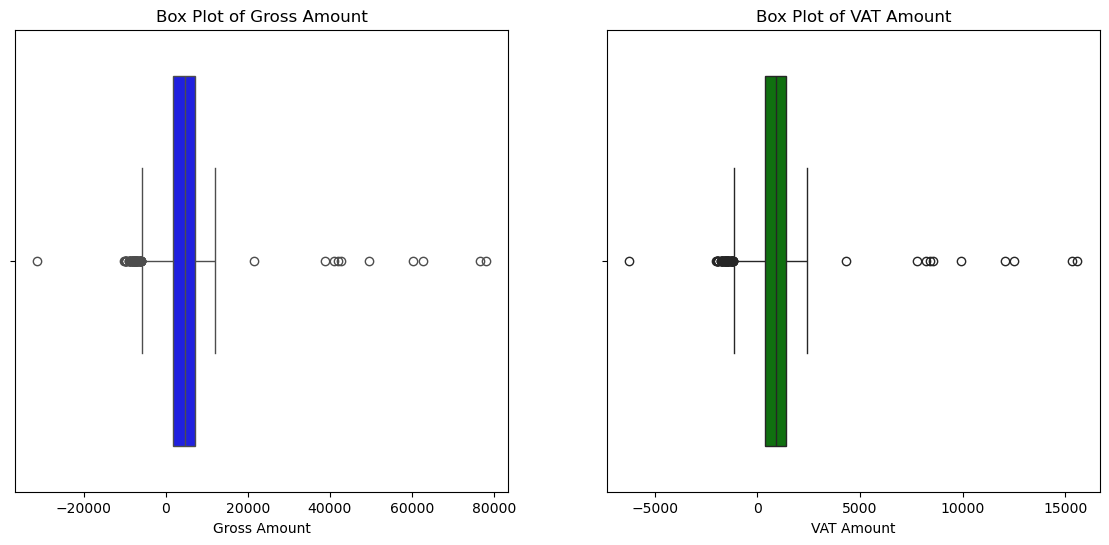

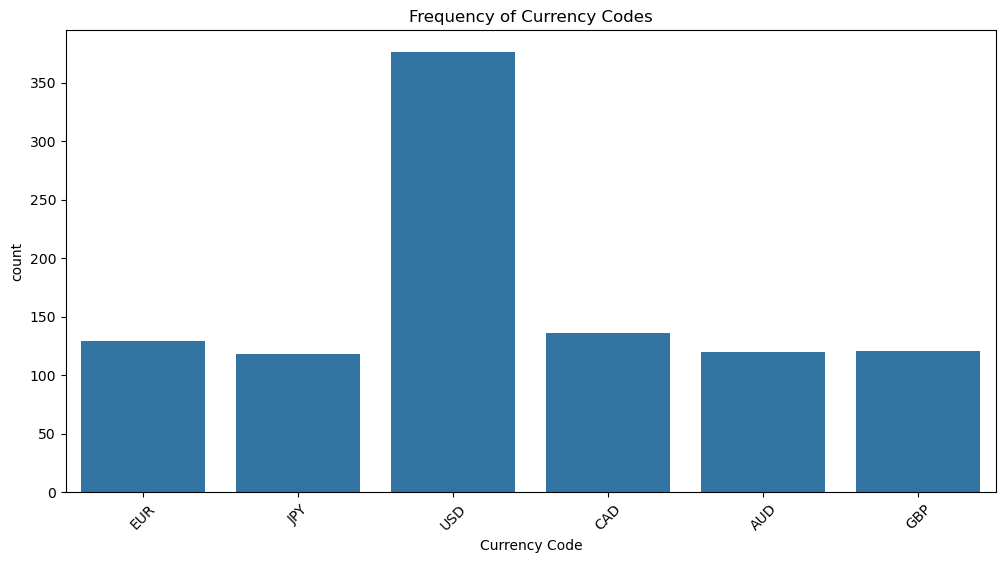

In [21]:
# Step 1: Field-Level Visualizations

# Histogram for Gross Amount and VAT Amount
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Gross Amount'], kde=True, color='blue', bins=20)
plt.title('Distribution of Gross Amount')

plt.subplot(1, 2, 2)
sns.histplot(df['VAT Amount'], kde=True, color='green', bins=20)
plt.title('Distribution of VAT Amount')

plt.show()

# Box plot for Gross Amount and VAT Amount to detect outliers
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Gross Amount'], color='blue')
plt.title('Box Plot of Gross Amount')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['VAT Amount'], color='green')
plt.title('Box Plot of VAT Amount')

plt.show()

# Frequency distribution for Categorical Fields
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Currency Code')
plt.title('Frequency of Currency Codes')
plt.xticks(rotation=45)
plt.show()


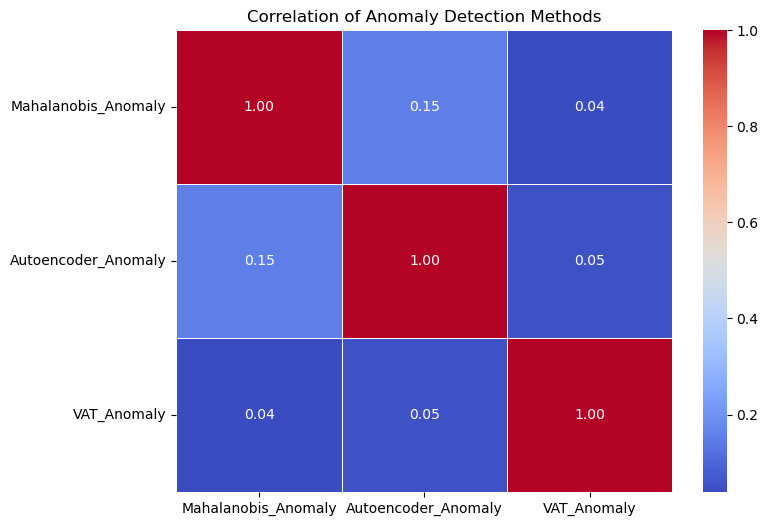

In [22]:
import seaborn as sns

# Combine the anomaly flags for Mahalanobis, Autoencoder, and Rule-Based anomalies
anomaly_flags = df[['Mahalanobis_Anomaly', 'Autoencoder_Anomaly', 'VAT_Anomaly']]

# Calculate correlation matrix
correlation_matrix = anomaly_flags.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation of Anomaly Detection Methods')
plt.show()


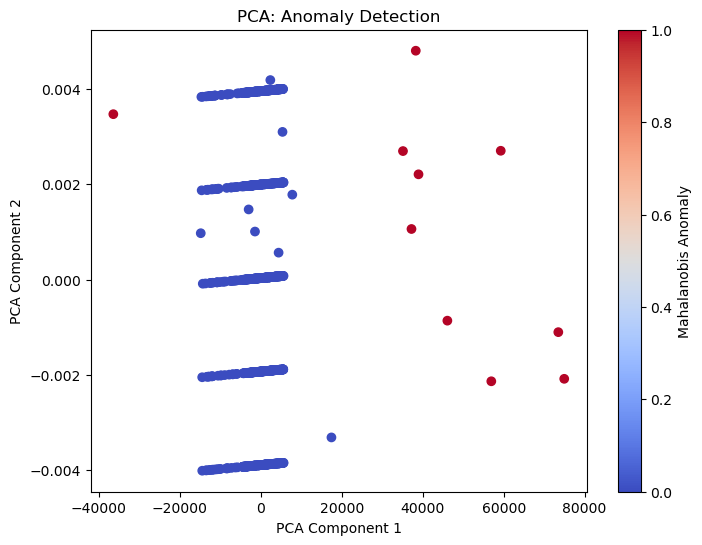

In [23]:
from sklearn.decomposition import PCA

# Step 3: PCA for Dimensionality Reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df[numeric_features])

# Plot PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['Mahalanobis_Anomaly'], cmap='coolwarm', label='Mahalanobis Anomaly')
plt.title('PCA: Anomaly Detection')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Mahalanobis Anomaly')
plt.show()


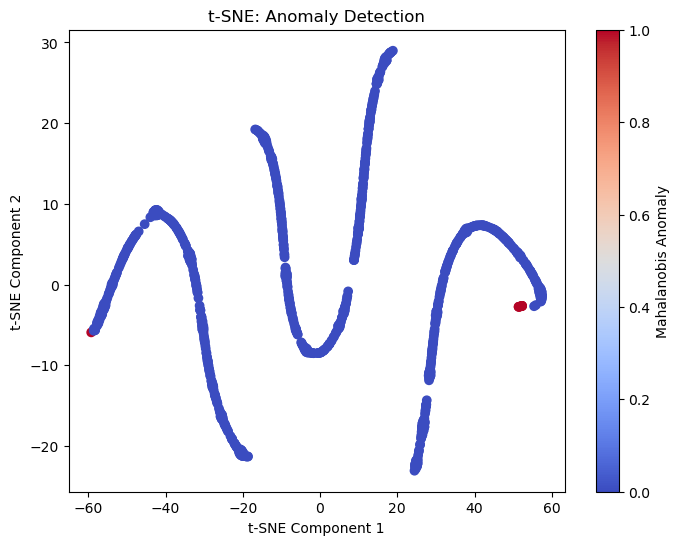

In [24]:
from sklearn.manifold import TSNE

# Step 3: t-SNE for Dimensionality Reduction
tsne = TSNE(n_components=2)
tsne_components = tsne.fit_transform(df[numeric_features])

# Plot t-SNE components
plt.figure(figsize=(8, 6))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=df['Mahalanobis_Anomaly'], cmap='coolwarm', label='Mahalanobis Anomaly')
plt.title('t-SNE: Anomaly Detection')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Mahalanobis Anomaly')
plt.show()
